# MNIST patches

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Pad images with 5x5 padding

In [3]:
kernel_size = 5
train_images_padded = np.pad(train_images, ((0, 0), (kernel_size - 1, kernel_size - 1), (kernel_size - 1, kernel_size - 1)))
train_images_padded.shape

(60000, 36, 36)

In [4]:
def make_patches(image, p=5):
    width, height = image.shape
    patches = np.random.randn((width - p + 1) * (height - p + 1), p, p)
    for i in range(width - p + 1):
        for j in range(height - p + 1):
            patches[i * (height - p + 1) + j] = image[i:i + p, j:j + p]
            
    return patches

for img in train_images_padded[:1]:
    patches = make_patches(img)
patches.shape

(1024, 5, 5)

In [5]:
def out_size(img_size, kernel_size, stride, padding):
    return (img_size + 2 * padding - (kernel_size - 1) - 1) // stride + 1

def conv2d_patches(img, kernel_size=(5, 5), stride=1, padding=0):
    (img_width, img_height) = img.shape
    (kernel_width, kernel_height) = kernel_size
    out_width, out_height = out_size(img_width, kernel_width, stride, padding), out_size(img_height, kernel_height, stride, padding)

    padded_img = np.pad(img, ((padding, padding), (padding, padding)))
    out = np.empty((out_width, out_height, kernel_width, kernel_height))
    for i, x in enumerate(range(0, out_width, stride)):
        for j, y in enumerate(range(0, out_height, stride)):
            out[i, j] = padded_img[x:x + kernel_width, y:y + kernel_height]
    return out / 255

wolla = conv2d_patches(train_images[0])

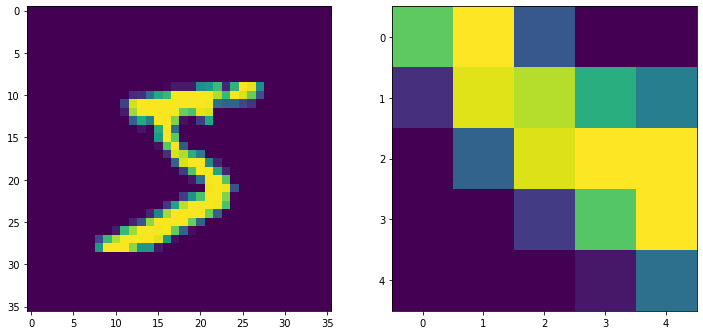

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(train_images_padded[0])
axs[1].imshow(wolla[12, 12])

## Neuron model

In [16]:
rng = np.random.default_rng()

class LIFEnsemble:
    
    def __init__(self, num_pixels, num_neurons):
        self.num_neurons = num_neurons

        self.exc_weights = rng.uniform(size=(num_neurons, num_pixels))
        self.inh_weights = np.zeros((num_neurons, num_neurons))
        self.thresholds = np.full(num_neurons, fill_value=5.0)

        self.reset()
        
        self.alpha = 0.01
        self.beta = 0.0001
        self.rho = 0.05
        self.gamma = 0.02

    def reset(self):        
        self.membrane_potential = np.zeros(self.num_neurons)
        self.input_current = np.zeros(self.num_neurons)
        self.spikes = [np.zeros(self.num_neurons)]
        
    def step(self, pixels):
        self.input_current = self.exc_weights @ pixels - self.inh_weights @ self.spikes[-1]
        self.membrane_potential += self.input_current - self.membrane_potential
        
        self.spikes.append(self.membrane_potential > self.thresholds)
        self.membrane_potential *= ~self.spikes[-1]
        
    def update(self, pixels):
        n_i = np.stack(self.spikes[1:]).sum(0)
        
        self.inh_weights += self.alpha * (np.outer(n_i, n_i) - self.rho**2)
        self.inh_weights[np.diag_indices_from(self.inh_weights)] = 0
        # self.inh_weights = np.minimum(self.inh_weights, 0)

        self.exc_weights += self.beta * np.outer(n_i, pixels - n_i @ self.exc_weights)
        # self.exc_weights = np.maximum(self.exc_weights, 0)

        self.thresholds += self.gamma * (n_i - self.rho)
        
        self.reset()        

In [17]:
def plot_activations(ensemble, sample_image):    
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    for i, axs in enumerate(axs.flatten()):
        axs.imshow(ensemble.exc_weights[i].reshape(5, 5))
    plt.show()
    
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for filter_idx in range(16):
        image_activations = np.zeros((28, 28))
        image_padded = np.pad(sample_image, 4)
        for i in range(28):
            for j in range(28):
                activation = ensemble.exc_weights[filter_idx] @ image_padded[i:i + 5, j:j + 5].reshape(25)
                image_activations[i, j] = activation

        axs[filter_idx // 4][filter_idx % 4].imshow(image_activations)

    fig.suptitle('Filter activations')
    plt.show()

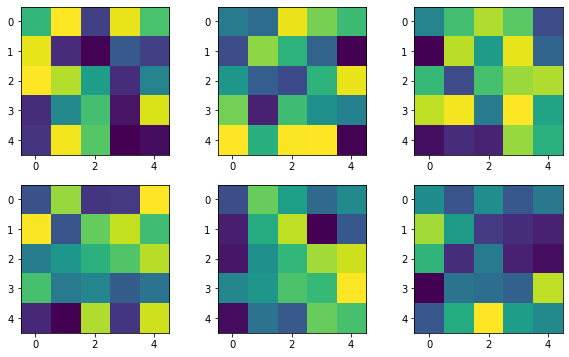

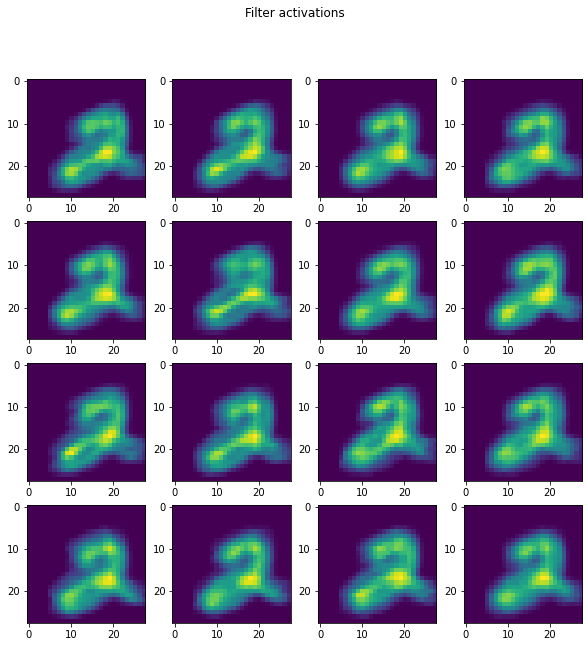

In [18]:
ensemble = LIFEnsemble(25, 16)
plot_activations(ensemble, train_images[5])

In [19]:
ensemble = LIFEnsemble(25, 16)
for image in tqdm(train_images[:100]):
    patches = conv2d_patches(image)
    for patch in patches.reshape(-1, 5, 5):
        for time_step in range(20):
            ensemble.step(patch.flatten())

        ensemble.update(patch.flatten())

  0%|          | 0/100 [00:00<?, ?it/s]

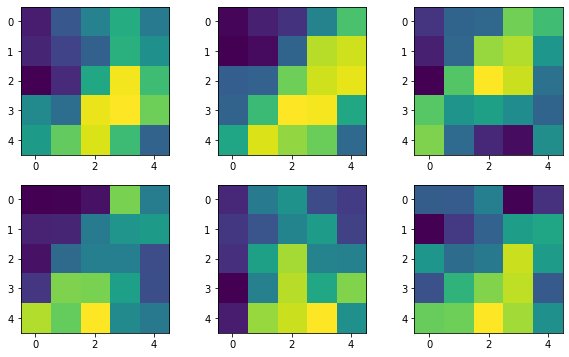

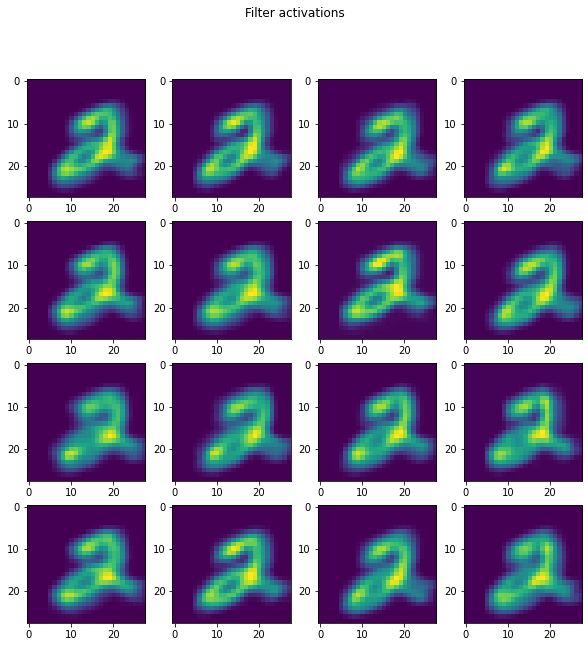

In [20]:
plot_activations(ensemble, train_images[5])

In [12]:
ensemble = LIFEnsemble(25, 16)
for image in tqdm(train_images[:1000]):
    patches = conv2d_patches(image)
    for patch in patches.reshape(-1, 5, 5):
        for time_step in range(20):
            ensemble.step(patch.flatten())

        ensemble.update(patch.flatten())

  0%|          | 0/1000 [00:00<?, ?it/s]

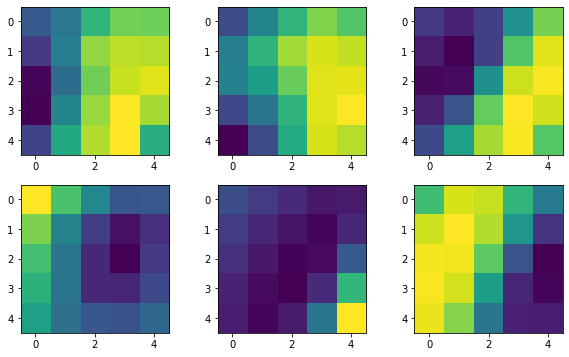

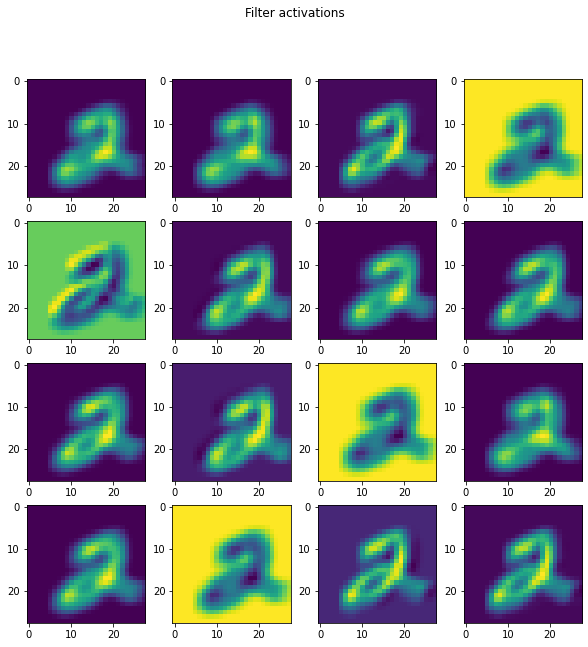

In [13]:
plot_activations(ensemble, train_images[5])

In [15]:
class IFEnsemble:    
    
    def __init__(self, input_values):
        self.input = input_values
        
        self.reset()
        
    def reset(self):
        self.membrane_potential = np.zeros(self.num_neurons)
        self.spike = np.zeros(self.num_neurons)        

    def step(self):
        self.membrane_potential += self.input
        self.spikes = self.membrane_potential >= 1
        self.membrane_potential -= self.input * self.spikes
        
        return self.spikes

In [ ]:
class ConvLayer:
    
    def __init__(self, exc_weights, in_ensemble):
        self.exc_weights = exc_weights
        self.num_pixels = len(in_ensemble.input)
        self.num_filters = exc_weights.shape[0]
        
        self.reset()       

    def reset(self):        
        self.membrane_potential = np.zeros((self.num_pixels, self.num_filters))
        self.input_current = np.zeros((self.num_pixels, self.num_filters))
        self.spikes = [np.zeros(self.num_neurons)]
        
    def step(self, pixels):
        pixels_ensemble = IFEnsemble(pixels)
        
        for t in range(20):
            pixel_spikes = pixels_ensemble.step()
        
            patches = conv2d_patches(pixels, padding=4).reshape(-1, 5, 5)
            for i, patch_i in enumerate(patches):
                self.input_current[i] = kernel @ pixel_spikes
                self.membrane_potential[i] += self.input_current[i]